# Treinamento e validação de Modelos - Dataset Combinado
Treinamento de um modelo usando como base um dataset combinado, constituído dos dois datasets utilizados ao longo do projeto: 
- Fake.br-Corpus: https://github.com/roneysco/Fake.br-Corpus
- FakeRecogna: https://github.com/Gabriel-Lino-Garcia/FakeRecogna 

Espera-se que um modelo treinado a partir de ambos datasets possua um desempenho melhor em uma maior variedade de notícias.

In [1]:
# Se necessário
%pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 435 kB 24.5 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [30]:
import os
import sagemaker
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score
from python_scripts.save_load import load_df_from_bucket, save_df_to_s3_bucket, save_to_s3_bucket_as_libsvm, BUCKET_MODEL
from python_scripts.modelling import create_train_validation_test_sets, setup_model, make_prediction
from python_scripts.plots import plot_confusion_matrix

## Carregamento de dados
O dataset combinado já foi criado e salvo no notebook `preprocessing.ipynb`. Aqui, ele é apenas carregado novamente a partir do S3.

In [32]:
model_df = load_df_from_bucket('dados_processados_combinados.csv', tipo='processado')
model_df.head()

,fake,lemmas_str
0,0,divisão STF meio partidário independente ficar...
1,1,general mandar recado STF abaixar calça congre...
2,1,nordeste acordar Lula PT enxotar chegar bandei...
3,0,dois relatório Polícia Federal análise materia...
4,1,Coreia Norte declarar status QUASE-GUERRA mobi...


## Modelo 1: TF-IDF baseado no texto da notícia
Vetorização TF-IDF é aplicada somente à coluna de texto da notícia. Demais colunas de dados não são consideradas.

In [33]:
# Tamanhos de teste e validação garantem que o arquivo de teste seja < 5 MB, facilita implementação
train_1, test_1, validate_1 = create_train_validation_test_sets(model_df, 
                                                                stratify_col='fake',
                                                                test_size=0.1, random_state=42,
                                                                validation_size=0.55)

### Processamento adicional

Um vetorizador TFIDF é utilizado para converter os dados textuais em colunas do DataFrame.

In [34]:
# Criar vetorizador TFIDF e ajustar aos dados de treinamento
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
tfidf.fit(train_1['lemmas_str'])

TfidfVectorizer(lowercase=False, ngram_range=(1, 2))

In [35]:
def create_x_y_1(base_df, tfidf, target_col='fake', lemma_col = 'lemmas_str'):
    tfidf_res = tfidf.transform(base_df[lemma_col])
    return tfidf_res, base_df[target_col]

x_train_1, y_train_1 = create_x_y_1(train_1, tfidf)
x_validate_1, y_validate_1 = create_x_y_1(validate_1, tfidf)
x_test_1, y_test_1 = create_x_y_1(test_1, tfidf)

### Upload de dados para o S3

In [7]:
file_name_tuples = [(x_train_1, y_train_1, 'train'), 
                   (x_test_1, y_test_1, 'test'), 
                   (x_validate_1, y_validate_1, 'validate')]

for x, y, prefix in file_name_tuples:
    save_to_s3_bucket_as_libsvm(x, y, prefix=prefix, filename='model_1_combo.libsvm', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazon

### Treinar modelo

In [8]:
xgb_model_1, data_channels_1 = setup_model(base_image='xgboost', model_name='model_1_combo', instance_count=4, 
                                           instance_type='ml.m4.xlarge')
xgb_model_1.fit(inputs=data_channels_1)

print('ready for hosting!')

2022-11-15 22:21:57 Starting - Starting the training job...ProfilerReport-1668550916: InProgress
...
2022-11-15 22:22:48 Starting - Preparing the instances for training............
2022-11-15 22:24:48 Downloading - Downloading input data...
2022-11-15 22:25:25 Training - Downloading the training image......
2022-11-15 22:26:16 Training - Training image download completed. Training in progress.[2022-11-15 22:26:20.549 ip-10-0-66-226.ec2.internal:8 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-15:22:26:20:INFO] Imported framework sagemaker_xgboost_container.training
[2022-11-15:22:26:20:INFO] Failed to parse hyperparameter eval_metric value map to Json.
Returning the value itself
[2022-11-15:22:26:20:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2022-11-15:22:26:20:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-15:22:26:20:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-11-15:22:26:20:INFO

In [9]:
xgb_predictor_1 = xgb_model_1.deploy(initial_instance_count=1,
                                     serializer=sagemaker.serializers.LibSVMSerializer(),
                                     instance_type='ml.m4.xlarge')

----------!

### Métricas do modelo

In [39]:
y_pred_1 = make_prediction(xgb_predictor_1, model_name='model_1_combo')

# Alternativa para carregar resultados salvos em outra execução
# from python_scripts.save_load import BUCKET_MODEL
# y_pred_1 = pd.read_csv(f's3://{BUCKET_MODEL}/test/pred_1_combo.csv')

In [11]:
print(classification_report(y_test_1, y_pred_1))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       430
           1       0.88      0.94      0.91       429

    accuracy                           0.91       859
   macro avg       0.91      0.91      0.91       859
weighted avg       0.91      0.91      0.91       859



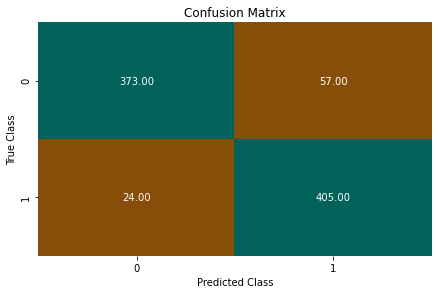

In [41]:
plot_confusion_matrix(y_test_1, y_pred_1)

In [42]:
precision_score(y_test_1, y_pred_1)

0.8766233766233766

Verifica-se um excelente desempenho do modelo baseado no dataset combinado, com 87.7% de precisão. Todavia, como foi visto no notebook `model_fakebr.ipynb`, é necessário ter cautela ao extrapolar os resultados para verificação de notícias fora dos datasets estudados. Idealmente, o modelo seria aprimorado ao longo do tempo com cada vez mais textos de notícias, a fim de garantir sua precisão na detecção de notícias falsas.

Mais adiante neste mesmo notebook, um job de otimização de hiperparâmetros será executado para verificar a possibilidade de aprimorar aindam ais este modelo.

### Salvar predição

In [12]:
df_pred_alt = pd.DataFrame({'pred_1_combo': y_pred_1})
df_pred_alt.to_csv(f's3://{BUCKET_MODEL}/test/pred_1_combo.csv', encoding='utf-8', index=False)

### Encerrar modelo

In [13]:
xgb_predictor_1.delete_endpoint(delete_endpoint_config=True) 

## Modelo 2: Otimização de Hiperparâmetros
Este modelo é treinado analogamente ao primeiro modelo, porém aplicando otimização de hiperparâmetros para tentar otimizar o modelo.

In [4]:
# Tamanhos de teste e validação garantem que o arquivo de teste seja < 5 MB, facilita implementação
train_2, test_2, validate_2 = create_train_validation_test_sets(model_df, 
                                                                stratify_col='fake',
                                                                test_size=0.1, random_state=42,
                                                                validation_size=0.55)

### Processamento adicional

Mesmo processamento feito para o modelo 1.

In [5]:
# Criar vetorizador TFIDF e ajustar aos dados de treinamento
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
tfidf.fit(train_2['lemmas_str'])

TfidfVectorizer(lowercase=False, ngram_range=(1, 2))

In [6]:
def create_x_y_2(base_df, tfidf, target_col='fake', lemma_col = 'lemmas_str'):
    tfidf_res = tfidf.transform(base_df[lemma_col])
    return tfidf_res, base_df[target_col]

x_train_2, y_train_2 = create_x_y_2(train_2, tfidf)
x_validate_2, y_validate_2 = create_x_y_2(validate_2, tfidf)
x_test_2, y_test_2 = create_x_y_2(test_2, tfidf)

### Upload para o S3

In [7]:
file_name_tuples = [(x_train_2, y_train_2, 'train'), 
                   (x_test_2, y_test_2, 'test'), 
                   (x_validate_2, y_validate_2, 'validate')]

for x, y, prefix in file_name_tuples:
    save_to_s3_bucket_as_libsvm(x, y, prefix=prefix, filename='model_2_combo.libsvm', tipo='modelo')

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
/home/ec2-user/anaconda3/envs/amazon

### Preparar modelo e job de otimização

In [10]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
xgb_model_2, data_channels_2 = setup_model(base_image='xgboost', model_name='model_1_combo', instance_count=4, 
                                           instance_type='ml.m4.xlarge')

# Poucos hiperparâmetros para não estourar limite de 4h por sessão!
hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }

objective_metric_name = 'validation:map'
objective_type = 'Maximize'

tuner = HyperparameterTuner(xgb_model_2,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=5,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

### Treinamento com otimização

In [11]:
tuner.fit(inputs=data_channels_2, include_cls_metadata=False)
tuner.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [12]:
import boto3
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

#### Verificar os 10 melhores modelos

In [14]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(10)

,alpha,eta,num_round,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,49.561391,0.259112,45.0,sagemaker-xgboost-221116-1117-020-b545fd5f,Completed,0.97199,2022-11-16 12:15:55+00:00,2022-11-16 12:49:11+00:00,1996.0
8,66.598683,0.244566,48.0,sagemaker-xgboost-221116-1117-012-e282e691,Completed,0.97038,2022-11-16 11:31:06+00:00,2022-11-16 12:05:44+00:00,2078.0
1,74.659839,0.226359,45.0,sagemaker-xgboost-221116-1117-019-016fe685,Completed,0.96960,2022-11-16 12:07:11+00:00,2022-11-16 12:40:11+00:00,1980.0
2,57.713931,0.222073,39.0,sagemaker-xgboost-221116-1117-018-d3fe04f4,Completed,0.96870,2022-11-16 12:06:58+00:00,2022-11-16 12:36:57+00:00,1799.0
4,95.397894,0.194678,44.0,sagemaker-xgboost-221116-1117-016-234d158e,Completed,0.96628,2022-11-16 11:55:33+00:00,2022-11-16 12:27:57+00:00,1944.0
11,10.001457,0.128063,47.0,sagemaker-xgboost-221116-1117-009-99c0e431,Completed,0.96580,2022-11-16 11:28:46+00:00,2022-11-16 12:14:33+00:00,2747.0
3,86.324840,0.205370,35.0,sagemaker-xgboost-221116-1117-017-d9a4aab3,Completed,0.96281,2022-11-16 11:56:07+00:00,2022-11-16 12:23:01+00:00,1614.0
13,92.812663,0.174142,39.0,sagemaker-xgboost-221116-1117-007-9d3656d2,Completed,0.96130,2022-11-16 11:24:23+00:00,2022-11-16 11:55:05+00:00,1842.0
7,67.147442,0.196464,30.0,sagemaker-xgboost-221116-1117-013-e640cd61,Completed,0.95900,2022-11-16 11:32:11+00:00,2022-11-16 11:55:54+00:00,1423.0
6,64.359910,0.300000,14.0,sagemaker-xgboost-221116-1117-014-15a7cf62,Completed,0.94415,2022-11-16 11:40:55+00:00,2022-11-16 11:53:27+00:00,752.0


### Criar modelo com melhor training job e fazer predição

In [15]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

In [16]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model()


2022-11-16 12:49:13 Starting - Found matching resource for reuse
2022-11-16 12:49:13 Downloading - Downloading input data
2022-11-16 12:49:13 Training - Training image download completed. Training in progress.
2022-11-16 12:49:13 Uploading - Uploading generated training model
2022-11-16 12:49:13 Completed - Resource retained for reuse


In [18]:
xgb_predictor_2 = best_algo_model.deploy(initial_instance_count=1,
                                     serializer=sagemaker.serializers.LibSVMSerializer(),
                                     instance_type='ml.m4.xlarge')

------------!

In [19]:
y_pred_2 = make_prediction(xgb_predictor_2, model_name='model_2_combo')

### Métricas do modelo

In [22]:
print(classification_report(y_test_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       430
           1       0.88      0.94      0.91       429

    accuracy                           0.91       859
   macro avg       0.91      0.91      0.91       859
weighted avg       0.91      0.91      0.91       859



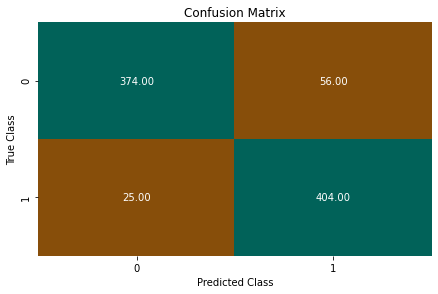

In [29]:
plot_confusion_matrix(y_test_2, y_pred_2)

In [31]:
precision_score(y_test_2, y_pred_2)

0.8782608695652174

O modelo otimizado apresentou uma melhora marginal comparado ao modelo original; a nova precisão obtida é de 87.8%, comparada à precisão de 87.7% do primeiro modelo treinado neste notebook. Uma exploração de maior gama de possíveis hiperparâmetros eventualmente poderia resultar em uma melhora mais significativa do modelo.

### Encerrar modelo

In [43]:
xgb_predictor_2.delete_endpoint(delete_endpoint_config=True)